### Compares LGARTO (C) real examples against Hydrus
### Date: 14 August, 2023 (last updated)
### By Ahmad Jan and Peter La Follette

In [ ]:
#This notebook demonstrates LGARTO's ability to emulate Richards equation solver results 
#at the USDA SCAN site near Geneva, NY.

In [128]:
import numpy as np
from matplotlib import pyplot as plt
import sys, os
import importlib as imp
import copy
import pandas as pd
import datetime as dt

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.dates as mdates

import pickle
import hydroeval

In [129]:
# C version
sim_case = 'outputs/Geneva/data_variables.csv' 
c_path_vars = sim_case

outfile = "c-hydrus-comparison_Geneva.png"
outfile_summpary_plot = "c-hydrus-comparison_Geneva_summary.png"

save_outfile = True

In [130]:
num_steps = 8760
    
start = pd.Timestamp("2020-10-01 00:00:00")
end = pd.Timestamp("2021-10-01 00:00:00")
times = pd.date_range(start=start,end=end, periods=num_steps) #freq='min'
times_bmi = pd.date_range(start=start,end=end, periods=num_steps)

xfmt = mdates.DateFormatter('%Y/%m/%d')


In [131]:
data_c_vars = pd.read_csv(c_path_vars)
data_c_vars = data_c_vars[0:num_steps]
data_c_vars.head()

,Time,precipitation,potential_evapotranspiration,actual_evapotranspiration,surface_runoff,giuh_runoff,soil_storage,total_discharge,infiltration,percolation,groundwater_to_stream_recharge,mass_balance
0,2020-10-01 00:00:00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.488087,0.0,0.0,0.000000e+00,0.0,0.0
1,2020-10-01 01:00:00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.488087,0.0,0.0,-1.233900e-11,0.0,-0.0
2,2020-10-01 02:00:00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.488087,0.0,0.0,-1.213300e-11,0.0,-0.0
3,2020-10-01 03:00:00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.488087,0.0,0.0,-1.193000e-11,0.0,0.0
4,2020-10-01 04:00:00,0.0,1.872001e-08,1.862037e-08,0.0,0.0,0.488087,0.0,0.0,-1.173100e-11,0.0,0.0


In [132]:
m_to_mm = 1000


### Read Hydrus data

In [133]:
hyd_path = 'HYDRUS_outputs/Geneva/T_Level.txt'


HYDRUS_output = pd.read_fwf(hyd_path,widths=[13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13])            
HYDRUS_datetime_vec = []
i=0
prior_dt = dt.datetime.strptime(data_c_vars['Time'][0],'%Y-%m-%d %H:%M:%S') + dt.timedelta(hours=HYDRUS_output['Time'][i]-1)
for i in range(0,len(HYDRUS_output['Time'])):
    current_dt = dt.datetime.strptime(data_c_vars['Time'][0],'%Y-%m-%d %H:%M:%S') + dt.timedelta(hours=HYDRUS_output['Time'][i])
    if (current_dt!=prior_dt):
        HYDRUS_datetime_vec.append(current_dt)
    else:
        HYDRUS_output = HYDRUS_output.drop(i)
    prior_dt = current_dt
HYDRUS_output['HYDRUS_datetime_vec'] = HYDRUS_datetime_vec
HYDRUS_output = HYDRUS_output.set_index('HYDRUS_datetime_vec')


In [134]:
len(HYDRUS_output)

8760

In [135]:
HYDRUS_output = HYDRUS_output.drop_duplicates()

In [136]:
len(HYDRUS_output)

8760

In [137]:

# HYDRUS_output = HYDRUS_output.resample('3600s').pad()

HYDRUS_output.head()

,Time,rTop,rRoot,vTop,vRoot,vBot,sum(rTop,) sum(rRoot,) sum(vTop,) sum(vRoot,...,hRoot,hBot,RunOff,sum(RunOff,) Volume,sum(Infil,) sum(Evap,) TLevel Cum(,WTrans) Snow,Layer
HYDRUS_datetime_vec,,,,,,,,,,,,,,,,,,,,,
2020-10-01 01:00:00,1.0,0.0,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000e+00,0.000000,...,-190.25,0.0,0.0,0.0,53.678,0.0,0.0,1 0.00,0.0,0.0
2020-10-01 02:00:00,2.0,0.0,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000e+00,0.000000,...,-190.25,0.0,0.0,0.0,53.678,0.0,0.0,2 0.00,0.0,0.0
2020-10-01 03:00:00,3.0,0.0,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000e+00,0.000000,...,-190.25,0.0,0.0,0.0,53.678,0.0,0.0,3 0.00,0.0,0.0
2020-10-01 04:00:00,4.0,0.0,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000e+00,0.000000,...,-190.25,0.0,0.0,0.0,53.678,0.0,0.0,4 0.00,0.0,0.0
2020-10-01 05:00:00,5.0,0.0,0.000002,-7.264200e-09,0.000002,0.0,0.0,0.000002,-7.264200e-09,0.000002,...,-190.25,0.0,0.0,0.0,53.678,0.0,0.0,5 0.00,0.0,0.0


In [138]:
len(HYDRUS_output)

8760

0       0.000000e+00
1      -1.233900e-09
2      -2.447200e-09
3      -3.640200e-09
4      -4.813300e-09
            ...     
8755   -7.790518e-02
8756   -7.791164e-02
8757   -7.791809e-02
8758   -7.792454e-02
8759   -7.793100e-02
Name: percolation, Length: 8760, dtype: float64


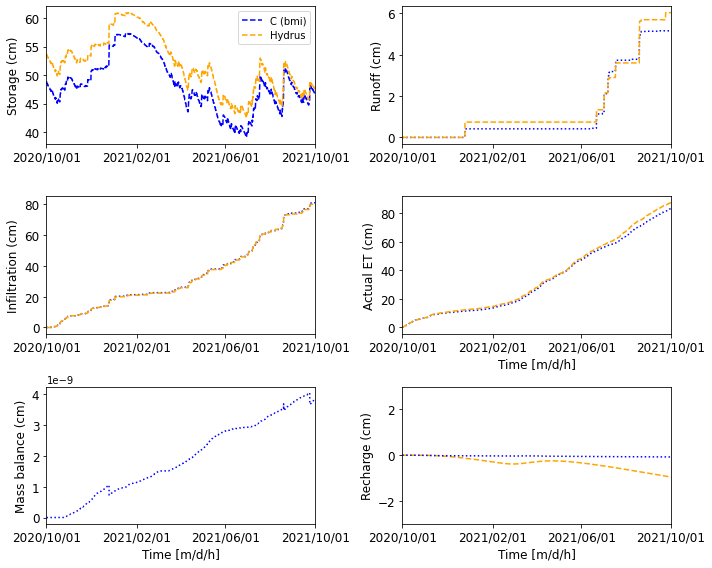

In [139]:



#%matplotlib qt
fig, axs = plt.subplots(3,2, figsize=(10,8), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1,1]})
fig.subplots_adjust(hspace =.02, wspace=1.02)
plt.tight_layout()
axs = axs.ravel()

vars_bmi = ['soil_storage', 'surface_runoff', 'infiltration', 'actual_evapotranspiration', 'mass_balance', 'percolation']
vars_hydrus = [')     Volume', 'sum(RunOff', 'sum(Infil', ')   sum(vRoot', ')    sum(vBot']
m_to_mm = 1000
m_to_cm = 100
timestep = 300/3600
y_labels = ['Storage (cm)', 'Runoff (cm)', 'Infiltration (cm)', 'Actual ET (cm)', 'Mass balance (cm)', 'Recharge (cm)']

for i in range(len(y_labels)):
    if i == 0:
        if i == 0:
            axs[i].plot(times_bmi, data_c_vars[vars_bmi[i]]*m_to_cm,'b',linestyle='dashed',label='C (bmi)')
            axs[i].plot(HYDRUS_output[vars_hydrus[i]],'k',linestyle='dashed',label='Hydrus',color='orange')
        else:
            hyd = []
            for t,v1 in zip(HYDRUS_output['Time'], HYDRUS_output[vars_hydrus[0]]):
                if t % 5.0 == 0:
                    hyd.append(v1)
            hyd_c_diff = []

            #hydrus output data does not include t=0 data
            for v2, v3 in zip(np.array(hyd),np.array(data_c_vars[vars_bmi[0]]*m_to_cm)[1:]):
                hyd_c_diff.append(abs(v2-v3))

            axs[i].legend()
        
    elif (i < len(vars_hydrus)-1):
        if i == 1 or i == 2 or i ==3 : 
            
            axs[i].plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[i]]*m_to_cm),'blue',linestyle='dotted',label='C (bmi)')  
            axs[i].plot(HYDRUS_output[vars_hydrus[i]],'k',linestyle='dashed',label='Hydrus',color='orange')
        if i==4:
            axs[i].plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[i]]*m_to_cm),'blue',linestyle='dotted',label='C (bmi)')
            axs[4].axis(ymin=-1,ymax=1)
    elif (i==4):
        axs[i].plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[i]]*m_to_cm),'blue',linestyle='dotted',label='C (bmi)')
        axs[5].plot(-1*HYDRUS_output[vars_hydrus[i]],'k',linestyle='dashed',label='Hydrus',color='orange')
        axs[5].axis(ymin=-3,ymax=3)
        print(np.cumsum(data_c_vars[vars_bmi[5]]*m_to_cm))
    else:
        axs[i].plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[i]]*m_to_cm),'b',linestyle='dotted',label='C (bmi)')

            
    axs[i].set_ylabel(y_labels[i],fontsize=12)
    
    if i >2:
        axs[i].set_xlabel('Time [m/d/h]',fontsize=12)
    axs[i].tick_params(axis='x', labelsize=12,rotation=0)
    axs[i].tick_params(axis='y', labelsize=12,rotation=0)
    axs[i].xaxis.set_major_formatter(xfmt)
    axs[i].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    
    axs[i].set_xlim(times_bmi[0], times_bmi[-1])
axs[0].legend()
plt.tight_layout()

if (save_outfile):
    plt.savefig(outfile,dpi=400)


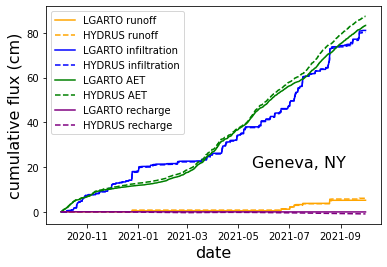

In [140]:
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'

plt.plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[1]]*m_to_cm),'b',label='C (bmi)',color='orange')
plt.plot(HYDRUS_output[vars_hydrus[1]],'k',linestyle='dashed',label='Hydrus',color='orange')

plt.plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[2]]*m_to_cm),'b',label='C (bmi)',color='blue')
plt.plot(HYDRUS_output[vars_hydrus[2]],'k',linestyle='dashed',label='Hydrus',color='blue')

plt.plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[3]]*m_to_cm),'b',label='C (bmi)',color='green')
plt.plot(HYDRUS_output[vars_hydrus[3]],'k',linestyle='dashed',label='Hydrus',color='green')

plt.plot(times_bmi, np.cumsum(data_c_vars[vars_bmi[5]]*m_to_cm),'b',label='C (bmi)',color='purple')
plt.plot(-1*HYDRUS_output[vars_hydrus[4]],'k',linestyle='dashed',label='Hydrus',color='purple')

leg = plt.legend()#(handles=[runoff_line_HYDRUS,runoff_line_HYDRUS,runoff_line_HYDRUS,runoff_line_HYDRUS],labels=["LGARTO", "HYDRUS", "theta_e", "capillary head = -depth"])

mylabels = ['LGARTO runoff','HYDRUS runoff','LGARTO infiltration','HYDRUS infiltration','LGARTO AET','HYDRUS AET','LGARTO recharge','HYDRUS recharge']

plt.legend(labels=mylabels)

plt.text(x=times_bmi[5500], y=20, s='Geneva, NY', fontsize = 16)

plt.ylabel("cumulative flux (cm)",fontsize=16)
plt.xlabel("date",fontsize=16)

# plt.vlines(times_bmi[3000], 0, 80, colors ="red")

if (save_outfile):
    plt.savefig(outfile_summpary_plot,dpi=400)

In [141]:
runoff_LGARTO = data_c_vars[vars_bmi[1]]*m_to_cm

runoff_HYDRUS = [0.0]
for i in range(1,len(HYDRUS_output)):
    runoff_HYDRUS.append(HYDRUS_output['sum(RunOff'][i] - HYDRUS_output['sum(RunOff'][i-1])

print("KGE in runoff: ")
print(hydroeval.kge(np.array(runoff_LGARTO), np.array(runoff_HYDRUS))[0][0])

print("NSE in runoff: ")
print(hydroeval.nse(np.array(runoff_LGARTO), np.array(runoff_HYDRUS)))

print("percent bias in runoff: ")
print(hydroeval.pbias(np.array(runoff_LGARTO), np.array(runoff_HYDRUS)))

print("RMSE in runoff (cm/h): ")
print(hydroeval.rmse(np.array(runoff_LGARTO), np.array(runoff_HYDRUS)))

print("cumulative runoff for LGARTO (cm): ")
print(np.sum(runoff_LGARTO))

print("cumulative runoff for HYDRUS (cm): ")
print(np.sum(runoff_HYDRUS))

print("difference (cm): ")
print(np.sum(runoff_HYDRUS) - np.sum(runoff_LGARTO))

KGE in runoff: 
0.837811603651269
NSE in runoff: 
0.877903822983634
percent bias in runoff: 
14.563638869093232
RMSE in runoff (cm/h): 
0.006345911488355209
cumulative runoff for LGARTO (cm): 
5.155742648805701
cumulative runoff for HYDRUS (cm): 
6.0346
difference (cm): 
0.8788573511942994


In [142]:
np.sum(runoff_HYDRUS) == HYDRUS_output['sum(RunOff'][-1]

True

In [143]:
infil_LGARTO = data_c_vars[vars_bmi[2]]*m_to_cm
infil_HYDRUS = HYDRUS_output['sum(Infil']#[1:]

infil_HYDRUS = np.array(infil_HYDRUS)
infil_HYDRUS_cumulative = HYDRUS_output['sum(Infil']#[1:]

i=0
for item in infil_HYDRUS:
#     print(item)
    if (i==0):
        item = item
    else:
        item = item - infil_HYDRUS_cumulative[i-1]
    infil_HYDRUS[i] = item
    i = i + 1
    
        
print("KGE in infiltration: ")
print(hydroeval.kge(np.array(infil_LGARTO), np.array(infil_HYDRUS))[0][0])

print("NSE in infiltration: ")
print(hydroeval.nse(np.array(infil_LGARTO), np.array(infil_HYDRUS)))

print("percent bias in infiltration: ")
print(hydroeval.pbias(np.array(infil_LGARTO), np.array(infil_HYDRUS)))

print("RMSE in infiltration (cm/h): ")
print(hydroeval.rmse(np.array(infil_LGARTO), np.array(infil_HYDRUS)))

print("cumulative infiltration for LGARTO (cm): ")
print(np.sum(infil_LGARTO))

print("cumulative infiltration for HYDRUS (cm): ")
print(np.sum(infil_HYDRUS))

print("difference (cm): ")
print(np.sum(infil_HYDRUS) - np.sum(infil_LGARTO))

KGE in infiltration: 
0.9844393693147659
NSE in infiltration: 
0.9855279088774429
percent bias in infiltration: 
-1.0965151530038773
RMSE in infiltration (cm/h): 
0.006348775227536284
cumulative infiltration for LGARTO (cm): 
81.1026573511943
cumulative infiltration for HYDRUS (cm): 
80.223
difference (cm): 
-0.8796573511942967


In [144]:
np.sum(infil_HYDRUS) == HYDRUS_output['sum(Infil'][-1]

True

In [145]:
AET_LGARTO = data_c_vars[vars_bmi[3]]*m_to_cm
# HYDRUS_output['vRoot'][0]=0.0
# AET_HYDRUS = HYDRUS_output['vRoot'][1:]
AET_HYDRUS = [0.0]
for i in range(1,len(HYDRUS_output)):
    AET_HYDRUS.append(HYDRUS_output[')   sum(vRoot'][i] - HYDRUS_output[')   sum(vRoot'][i-1])

HYDRUS_output[')   sum(vRoot'][-1] == np.sum(AET_HYDRUS)
    
print("KGE in AET: ")
print(hydroeval.kge(np.array(AET_LGARTO), np.array(AET_HYDRUS))[0][0])

print("NSE in AET: ")
print(hydroeval.nse(np.array(AET_LGARTO), np.array(AET_HYDRUS)))

print("percent bias in AET: ")
print(hydroeval.pbias(np.array(AET_LGARTO), np.array(AET_HYDRUS)))

print("RMSE in AET (cm/h): ")
print(hydroeval.rmse(np.array(AET_LGARTO), np.array(AET_HYDRUS)))

print("cumulative AET for LGARTO (cm): ")
print(np.sum(AET_LGARTO))

print("cumulative AET for HYDRUS (cm): ")
print(np.sum(AET_HYDRUS))

print("difference (cm): ")
print(np.sum(AET_HYDRUS) - np.sum(AET_LGARTO))

KGE in AET: 
0.938658678445491
NSE in AET: 
0.98752243110546
percent bias in AET: 
4.687867794835605
RMSE in AET (cm/h): 
0.0018125082594072632
cumulative AET for LGARTO (cm): 
83.3418815215178
cumulative AET for HYDRUS (cm): 
87.441
difference (cm): 
4.099118478482197


In [146]:
np.sum(AET_HYDRUS) == HYDRUS_output[')   sum(vRoot'][-1]

True

In [147]:
rch_LGARTO = data_c_vars[vars_bmi[5]]*m_to_cm
rch_HYDRUS = -1*HYDRUS_output['vBot']

print("KGE in recharge: ")
print(hydroeval.kge(np.array(rch_LGARTO), np.array(rch_HYDRUS))[0][0])

print("NSE in recharge: ")
print(hydroeval.nse(np.array(rch_LGARTO), np.array(rch_HYDRUS)))

print("percent bias in recharge: ")
print(hydroeval.pbias(np.array(rch_LGARTO), np.array(rch_HYDRUS)))

print("RMSE in recharge (cm/h): ")
print(hydroeval.rmse(np.array(rch_LGARTO), np.array(rch_HYDRUS)))

print("cumulative recharge for LGARTO (cm): ")
print(np.sum(rch_LGARTO))

print("cumulative recharge for HYDRUS (cm): ")
print(np.sum(rch_HYDRUS))

print("difference (cm): ")
print(np.sum(rch_HYDRUS) - np.sum(rch_LGARTO))


KGE in recharge: 
-0.436961849274504
NSE in recharge: 
-1.0514022923668263
percent bias in recharge: 
91.87661706104265
RMSE in recharge (cm/h): 
0.0001651003151343045
cumulative recharge for LGARTO (cm): 
-0.0779309991214
cumulative recharge for HYDRUS (cm): 
-0.95934168938
difference (cm): 
-0.8814106902586


In [148]:
abs(np.sum(rch_HYDRUS) - -1*HYDRUS_output[')    sum(vBot'][-1]) < 0.001

True

In [149]:
rch_HYDRUS=np.array(rch_HYDRUS)
rch_LGARTO=np.array(rch_LGARTO)

rch_HYDRUS_ind=np.array(rch_HYDRUS)
rch_LGARTO_ind=np.array(rch_LGARTO)

i = 0
for _ in rch_HYDRUS:
    if i>0:
        rch_HYDRUS[i] = np.sum(rch_HYDRUS_ind[0:i])
        rch_LGARTO[i] = np.sum(rch_LGARTO_ind[0:i])
    i=i+1

# plt.plot(rch_LGARTO)
# plt.plot(rch_HYDRUS)

print("KGE in cumulative recharge: ")
print(hydroeval.kge(np.array(rch_LGARTO), np.array(rch_HYDRUS))[0][0])

print("NSE in cumulative recharge: ")
print(hydroeval.nse(np.array(rch_LGARTO), np.array(rch_HYDRUS)))

print("percent bias in cumulative recharge: ")
print(hydroeval.pbias(np.array(rch_LGARTO), np.array(rch_HYDRUS)))

print("RMSE in cumulative recharge (cm): ")
print(hydroeval.rmse(np.array(rch_LGARTO), np.array(rch_HYDRUS)))




KGE in cumulative recharge: 
-0.26872439422694416
NSE in cumulative recharge: 
-1.237382640884999
percent bias in cumulative recharge: 
87.241648332011
RMSE in cumulative recharge (cm): 
0.38122068841059287
